# TP BE Météo

## Chargement des librairies

cf readme

In [53]:
library(sf)
library(ggplot2)
library("rnaturalearth")
library("rnaturalearthdata")
library(dplyr)
library(glue)
library(tidyr)

pcolors = c("#FFBE0B", "#FF006E", "#8338EC", "#5A96FF", "#880D1E", "#4CC9F0")

## Chargement des données

In [54]:
# 31s à s'exécuter sur Stuart
data_full_dir = "../data/donnees-synop-essentielles-omm.csv"
# 9s à s'exécuter sur stuart
data_ext10_dir = "../data/donnees_extracted_10.csv"
data_ext10M_dir = "../data/donnees_extracted_metro_10.csv"
data_ext_allM_dir = "../data/donnees_extracted_metro_all.csv"
# data : sur la metropole seulement
metro = TRUE

full_data <- read.csv(data_ext_allM_dir, 
            sep=",", # à toggle en fonction du fichier (',' pour les extracts, ';' pour l'originel)
            na.string=c("","null","NaN"),
            header=TRUE, 
            stringsAsFactors=TRUE)

## Fonction de dendogrammerie

Fonction de normalisation des données. Normalise toutes les données du dataframe, sauf les Latitudes et Longitudes. 

In [82]:
normalize <- function(df) {
  df_normalized <- df %>%
  mutate(across(
    .cols = -c(Latitude, Longitude),  # Select all columns except these
    .fns = ~ (. - min(., na.rm = TRUE)) / (max(., na.rm = TRUE) - min(., na.rm = TRUE))
  ))
  return(df_normalized)
}

Fonction qui :
* normalise les données d'entrée, sauf Latitude et Longitude
* Calcule les distances à partir de toutes les colonnes, sauf Latitude et Longitude
* dessine le dendogramme
* regroupe le dendogramme en nk groupes
* affiche les stations par groupes sur une carte du monde si metro=FALSE, de France si metro=TRUE

La normalisation est pertinente car les données (Pression, Température, etc) sont exprimées en différentes unités ayant différents ordres de grandeur.

In [92]:

auto_dendogram <- function(crit_data, nk, metro=FALSE){
    # normalize data
    crit_data <- normalize(crit_data)
    # distances on everythin BUT LATITUDE AND LONGITUDE
    distances <- dist(crit_data[, -which(names(crit_data) %in% c("Latitude", "Longitude"))])

    # la distance par défaut est 'complete', ie maximale.
    # plot dendrogramme and split tree
    cah_tree <- hclust(distances, method="ward.D")
    clusters <- cutree(cah_tree, k = nk, h = NULL)
    # display dendogram
    par(bg = 'white')
    options(repr.plot.width=16, repr.plot.height=10)
    plot(cah_tree, main = glue("Dendrogram with {nk} clusters"))
    rectlist = rect.hclust(cah_tree, k = nk, border = 2:(nk+1))

    # plot la hauteur en fonction du nombre de groupe
    par(bg = 'white')
    plot(cah_tree$height, col='red', type='l')
    grid(col="gray")

    # plot les groupes en couleur sur une carte du monde
    options(repr.plot.width=18, repr.plot.height=12)
    worldmap <- ne_countries(scale = 'medium', type = 'map_units', returnclass = 'sf')

    i <- 1
    p <- ggplot()
    if(metro){
        p <- p + geom_sf(data = worldmap[worldmap$name == 'France',], color = "black", fill = "#CAFFDA")
    }
    else{
        p <- p + geom_sf(data = worldmap, color = "black", fill = "#CAFFDA")
    }
    for(v in rectlist){
        p <- p + geom_point(data = crit_data[rownames(crit_data) %in% names(v), ], 
                aes(x = Longitude, y = Latitude), color = pcolors[[i]], size = 3)
    i <- (i+1)%%length(pcolors)
    }
    p <- p + coord_sf() + theme_minimal()
    print(p)
}

## Critère : latitude et longitude

Crée le dataframe avec les données nécessaires pour le dendrogramme. Exécute la fonction de dendrogrammage. Expérimentalement, nk=3 fonctionne bien pour les données monde et métropole.

Le regroupement se fait sur un critère de proximité géographique.

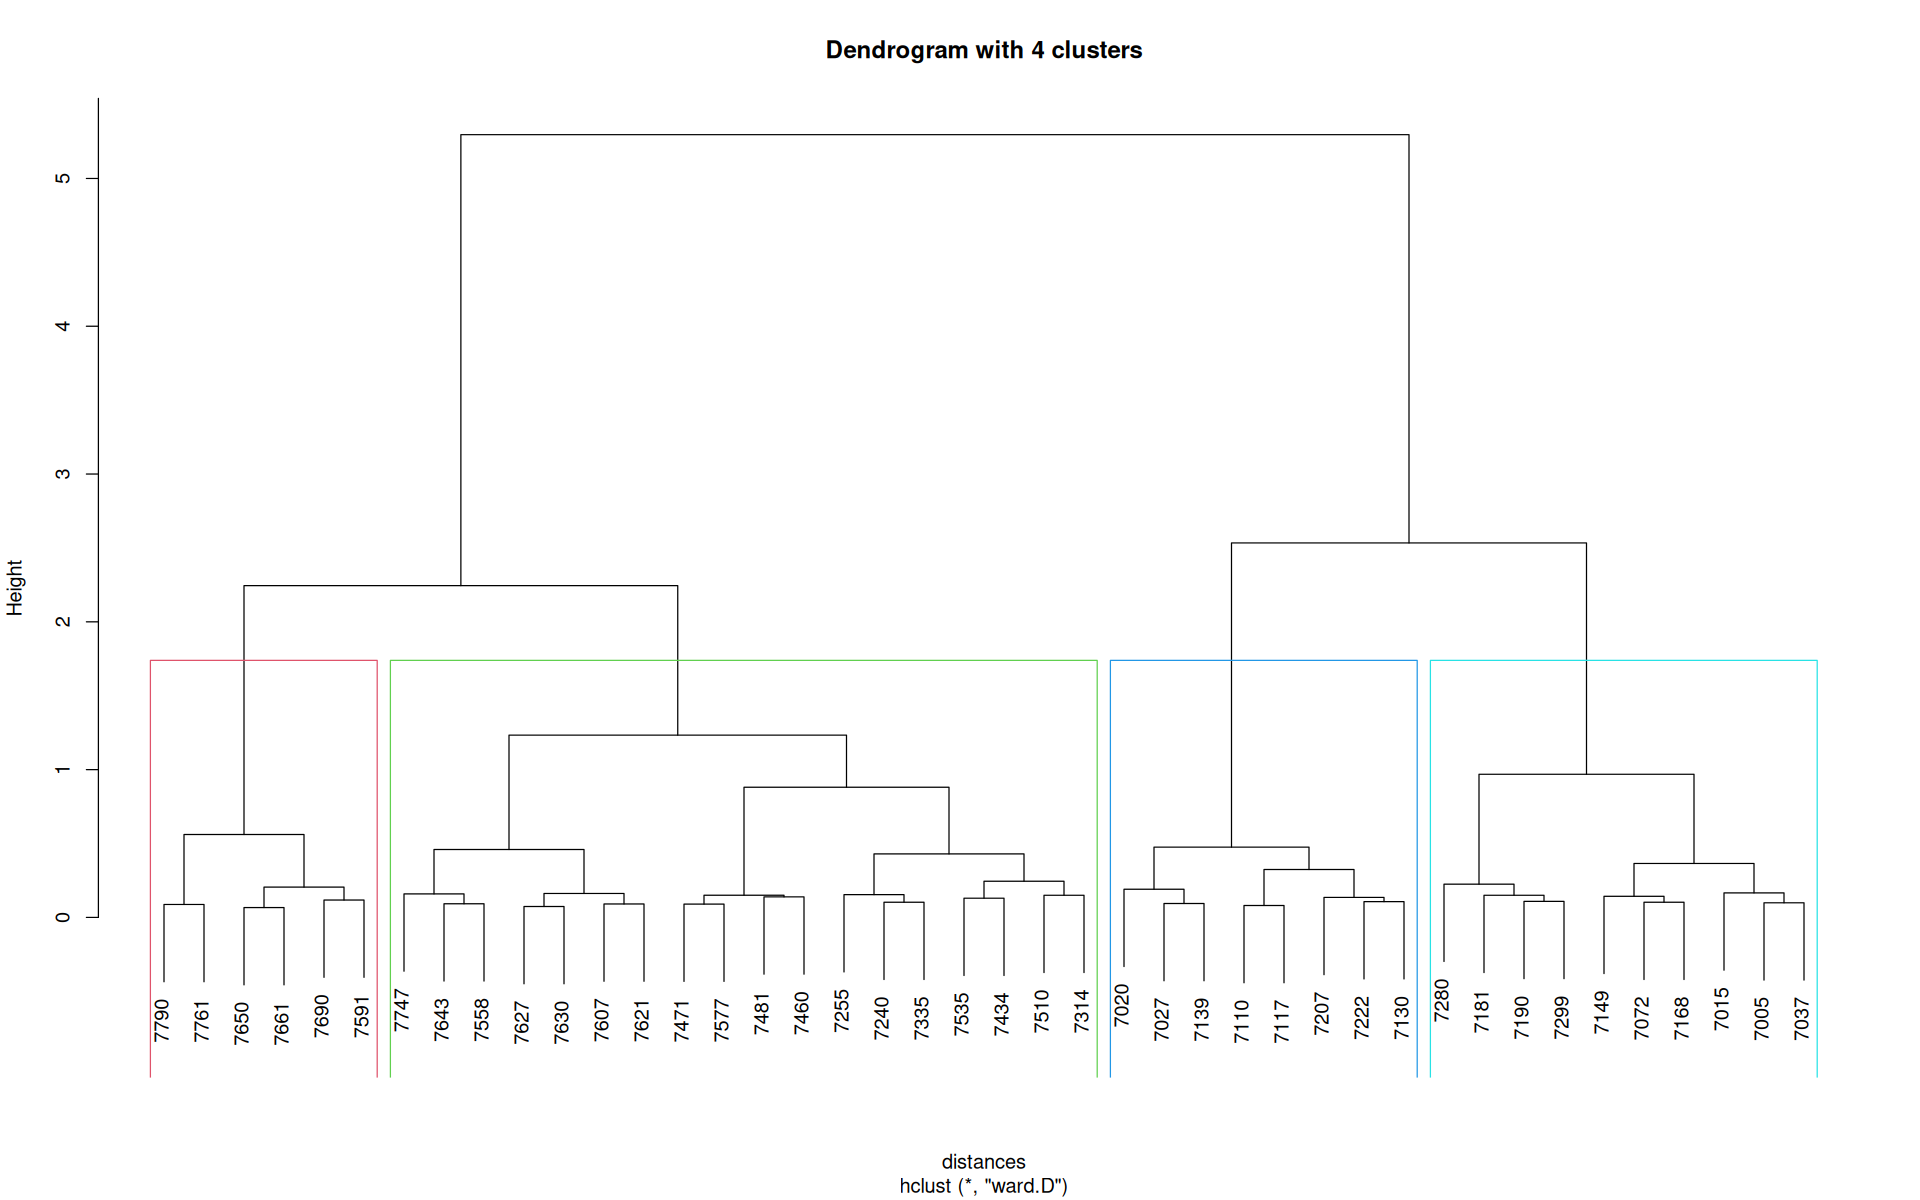

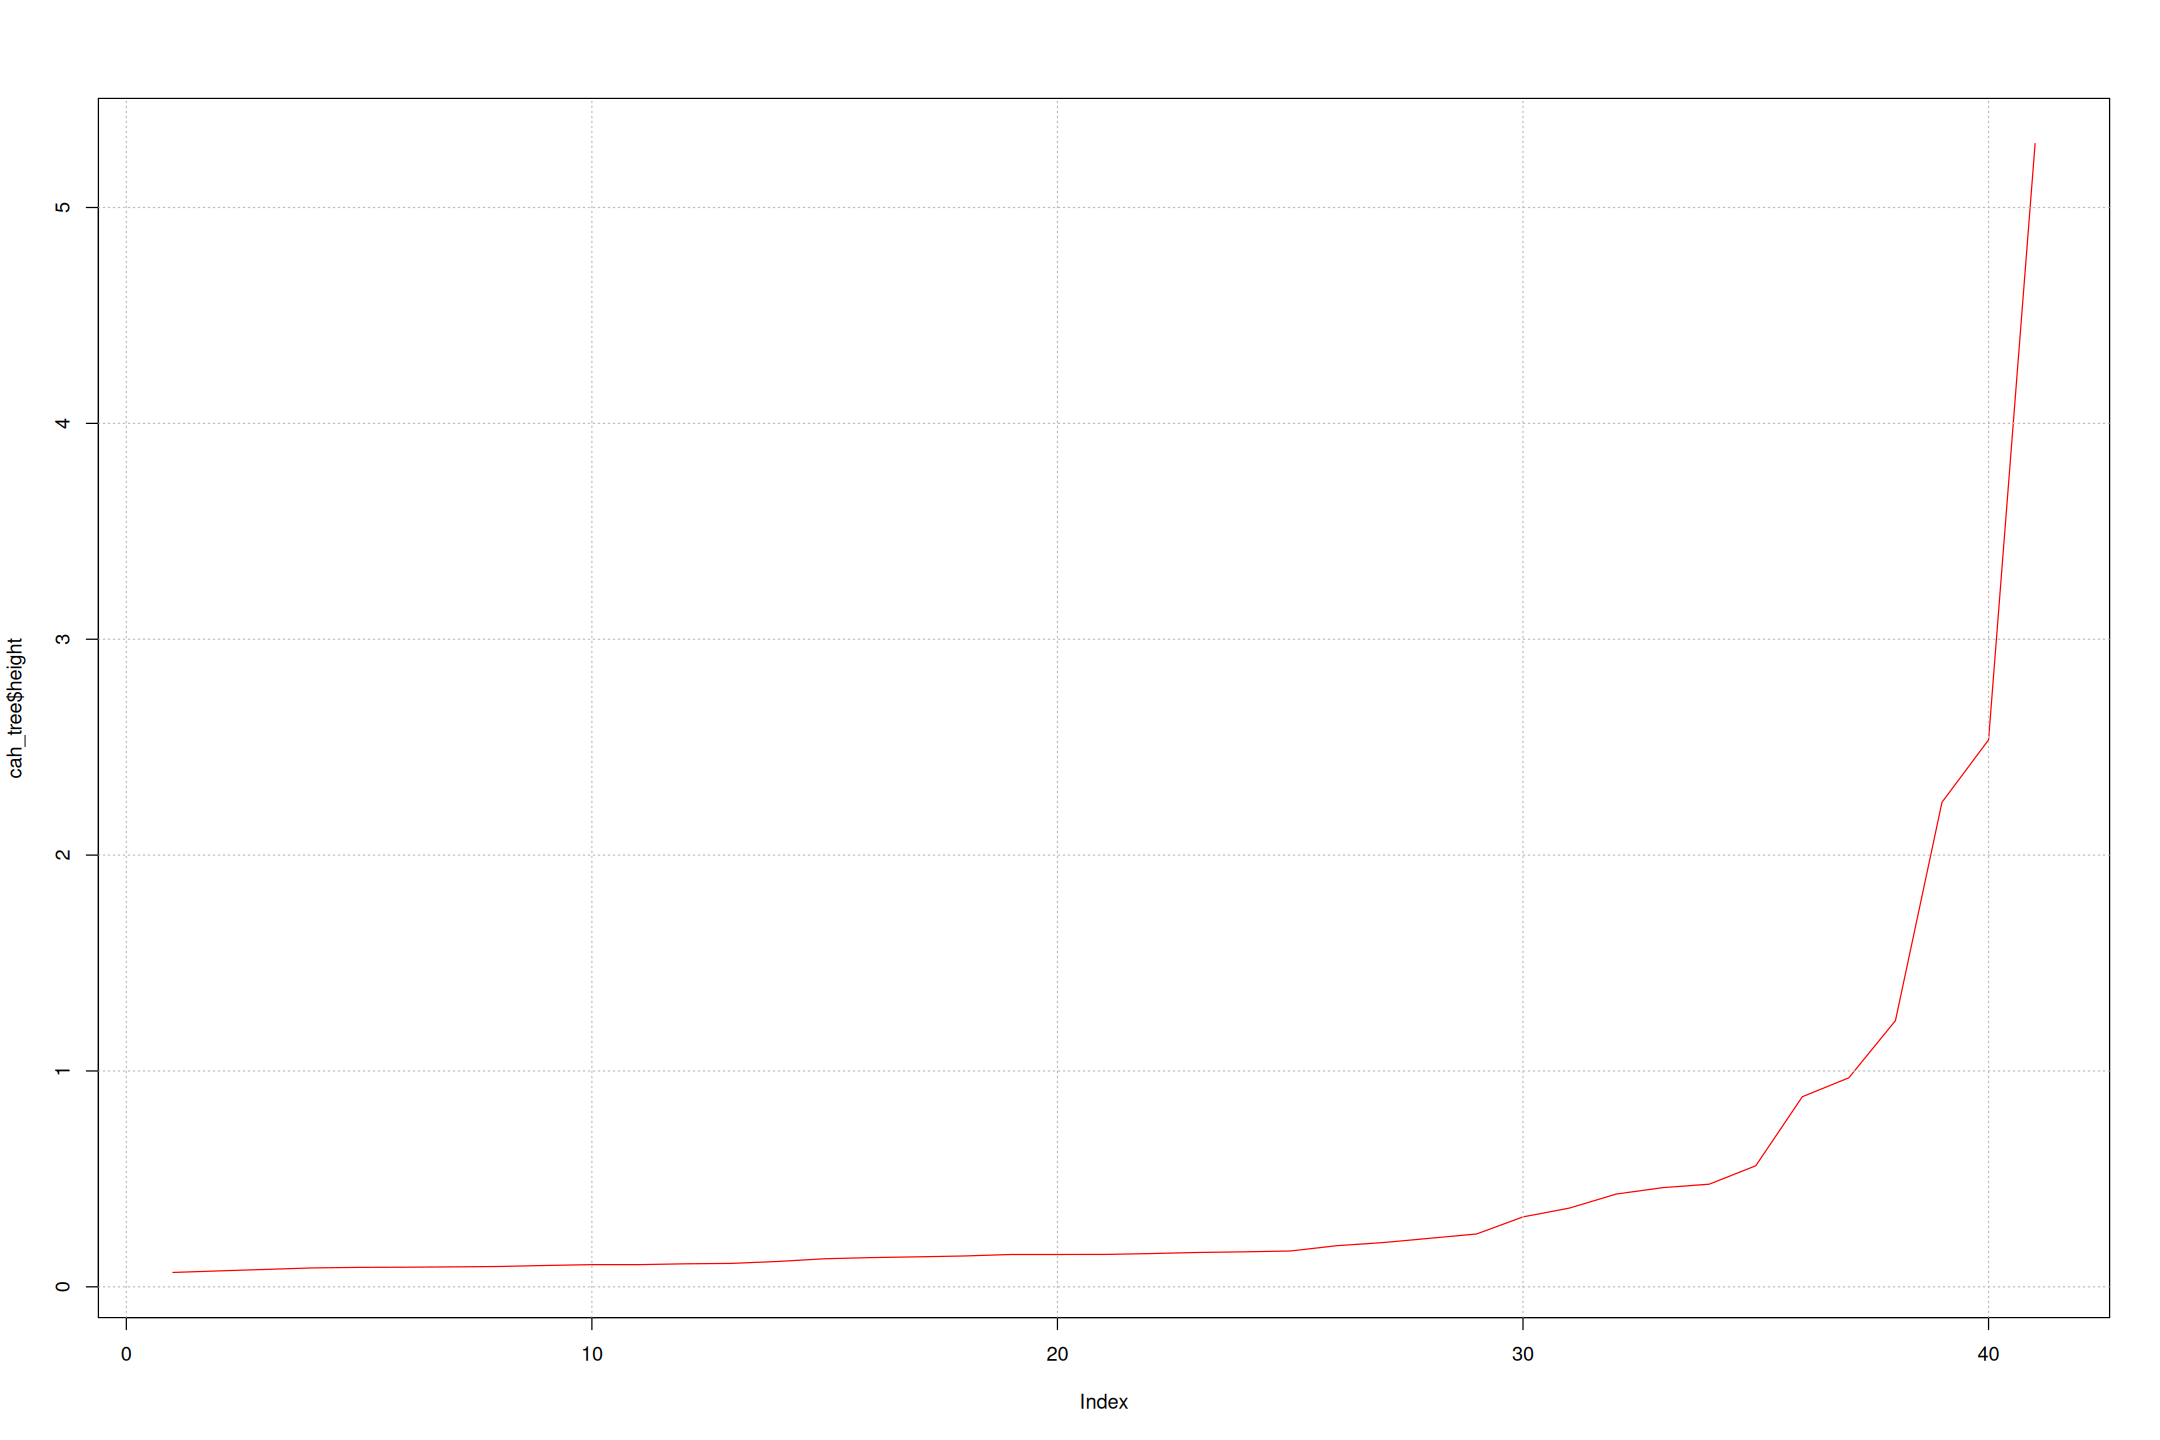

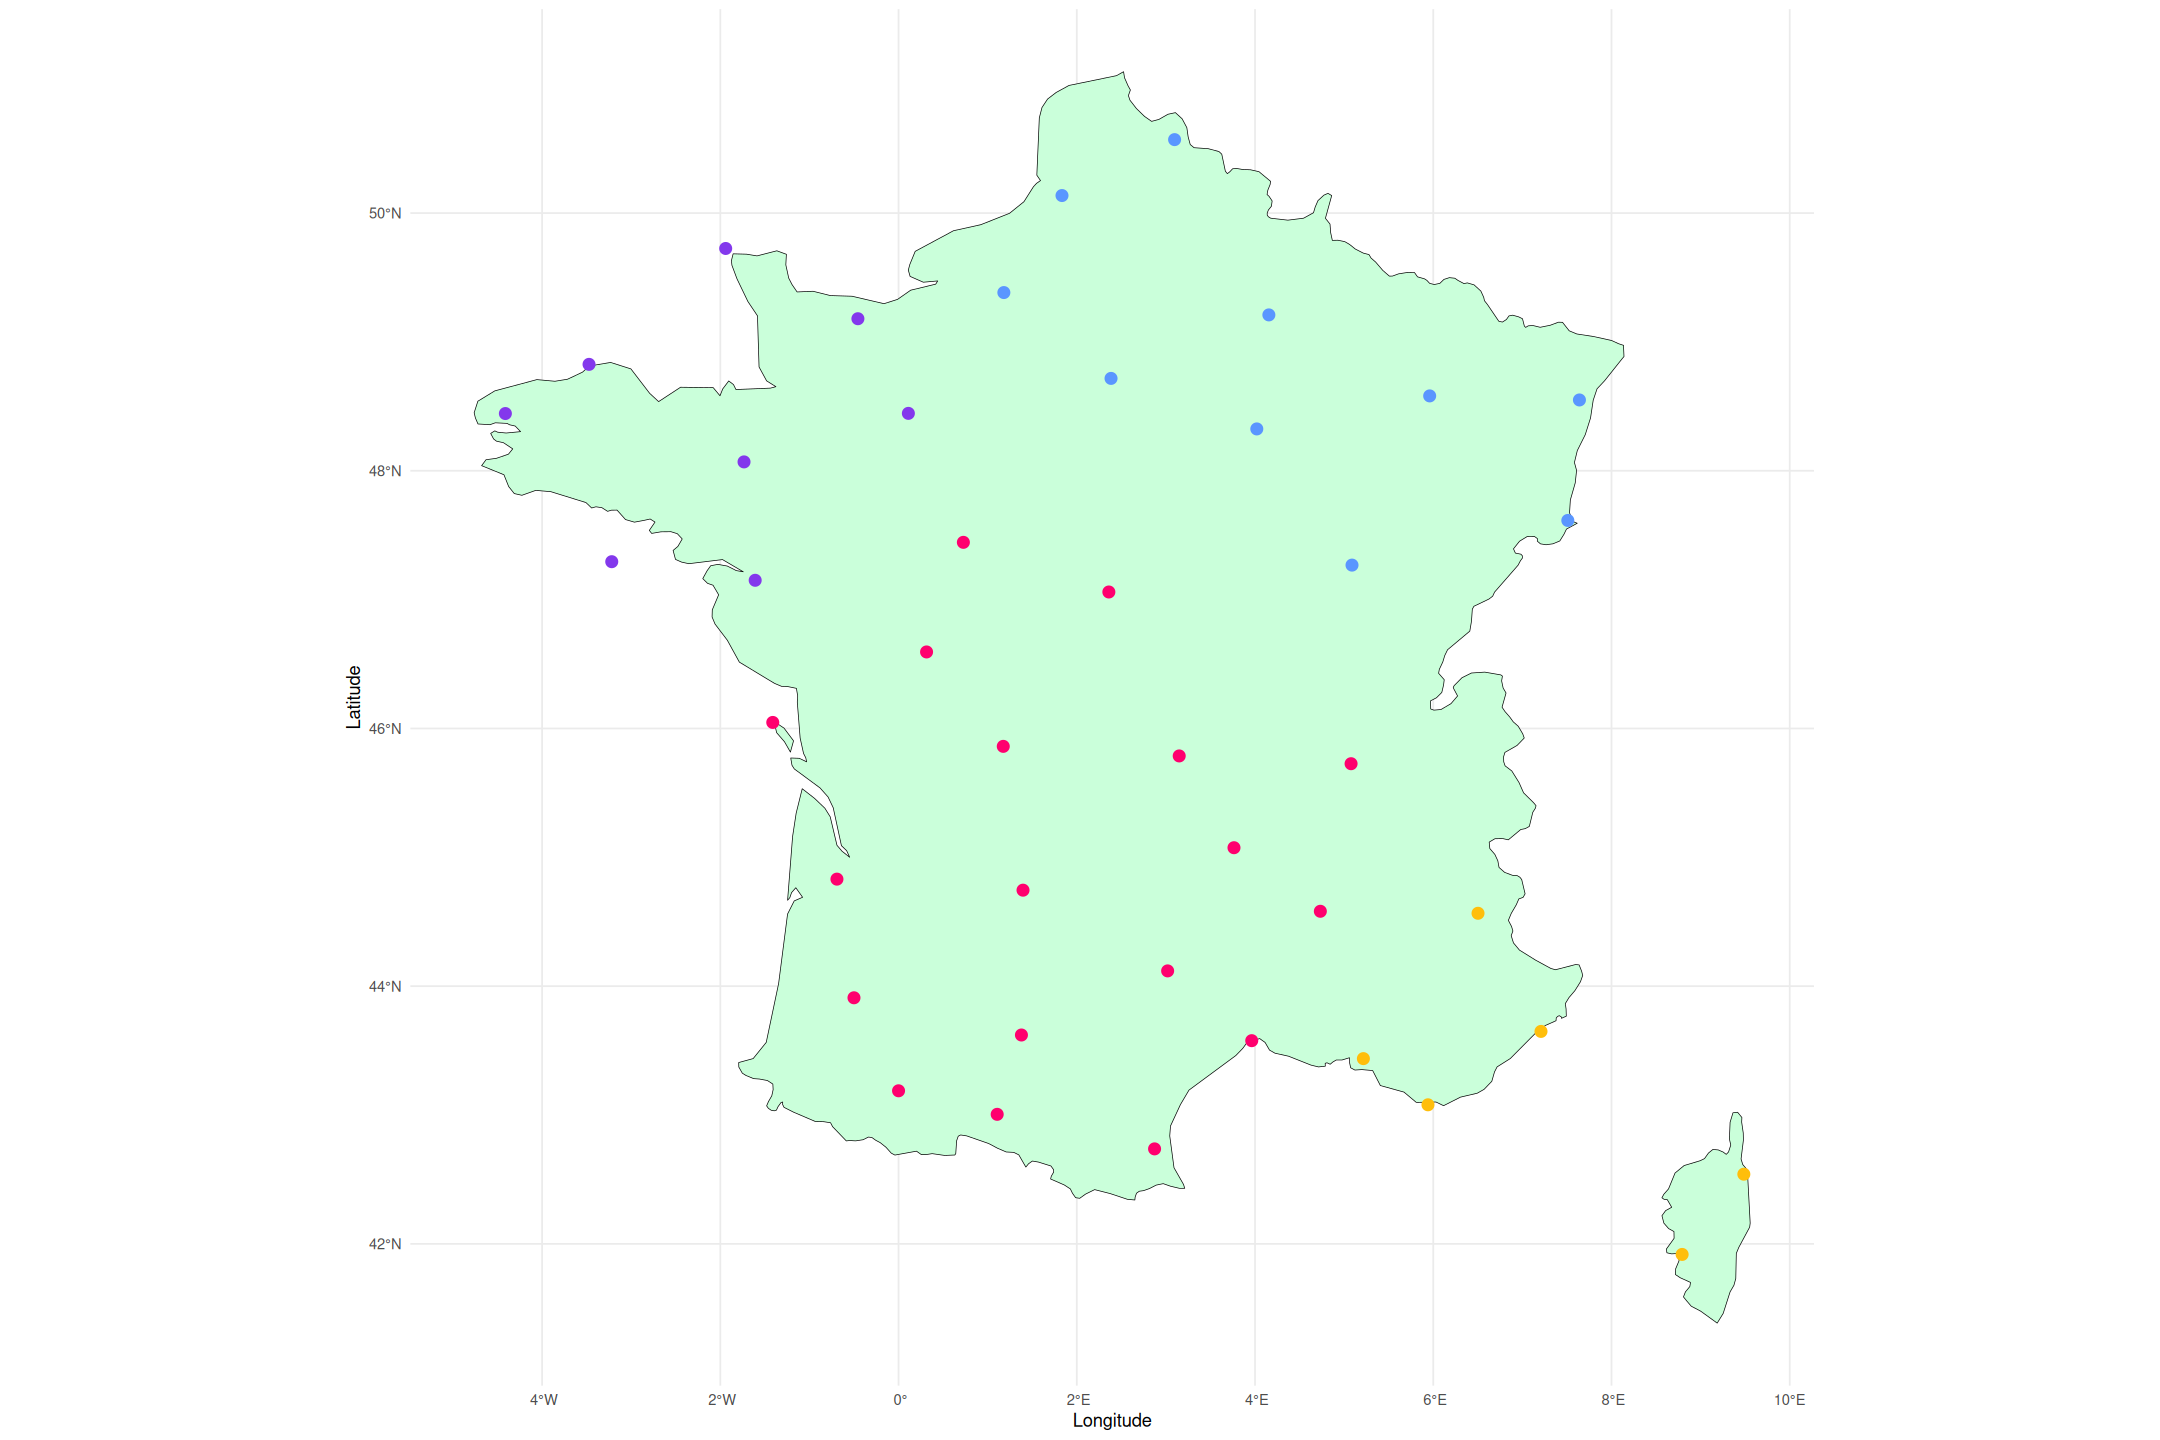

In [ ]:
# extract latitudes and longitude
geo_data <- full_data[, c("ID.OMM.station", "Latitude", "Longitude", "Latitude", "Longitude")]
# make it unique
geo_data <- geo_data[!duplicated(geo_data["ID.OMM.station"]), ]

# change names of the second latitude and longitude columns, because we want to use this data 
# for computing distances and auto_dendogram get rid of Lat and Long columns auotmatically
colnames(geo_data) = c("ID.OMM.station", "Latitude", "Longitude", "LatitudeMesure", "LongitudeMesure")

# replace names of rows by station id
row.names(geo_data) <- geo_data$ID.OMM.station
# and delete column
geo_data <- geo_data[, -which(names(geo_data) == "ID.OMM.station")]

# display dendogram and map
auto_dendogram(geo_data, nk=3, metro=metro)

## Critère : Température

Crée le dataframe avec les données nécessaires pour le dendrogramme. Exécute la fonction de dendrogrammage. Expérimentalement, nk=4 fonctionne bien pour les données monde et métropole.

Le regroupement des stations se fait sur les températures maximales et minimales calculées chaque mois, pour toutes les années. Par exemple, la température minimale de la station 7005, pour les mois de septembre de toutes les année.

In [95]:
# extract two columns temperatures for each station
temperature_data <- full_data[, c("ID.OMM.station", "Température...C.", "Température...C.", "mois_de_l_annee", "Latitude", "Longitude")]
colnames(temperature_data) = c("ID.OMM.station", "TempératureMin", "TempératureMax", "Mois", "Latitude", "Longitude")

# group temperatures by month and station, and take min and max for each month
temperature_monthly_data <- temperature_data %>% 
                    group_by(ID.OMM.station, Mois) %>% 
                    summarise(TempératureMin = min(TempératureMin, na.rm = TRUE),
                                TempératureMax = max(TempératureMax, na.rm = TRUE),
                                Latitude = min(Latitude, na.rm = TRUE),
                                Longitude = min(Longitude, na.rm = TRUE))

# group temperatures by station, min and max temperatures averaged on months
temperature_monthly_avg_data <- temperature_monthly_data %>% 
                    group_by(ID.OMM.station) %>% 
                    summarise(TempératureMinMoy = mean(TempératureMin, na.rm = TRUE),
                                TempératureMaxMoy = mean(TempératureMax, na.rm = TRUE),
                                Latitude = min(Latitude, na.rm = TRUE),
                                Longitude = min(Longitude, na.rm = TRUE))

# change row names to station nameds
temperature_monthly_avg_data <- as.data.frame(temperature_monthly_avg_data)
row.names(temperature_monthly_avg_data) <- temperature_monthly_avg_data$ID.OMM.station
# drop first column
temperature_monthly_avg_data <- temperature_monthly_avg_data[, -which(names(temperature_monthly_avg_data) == "ID.OMM.station")]


`summarise()` has grouped output by 'ID.OMM.station'. You can override using
the `.groups` argument.


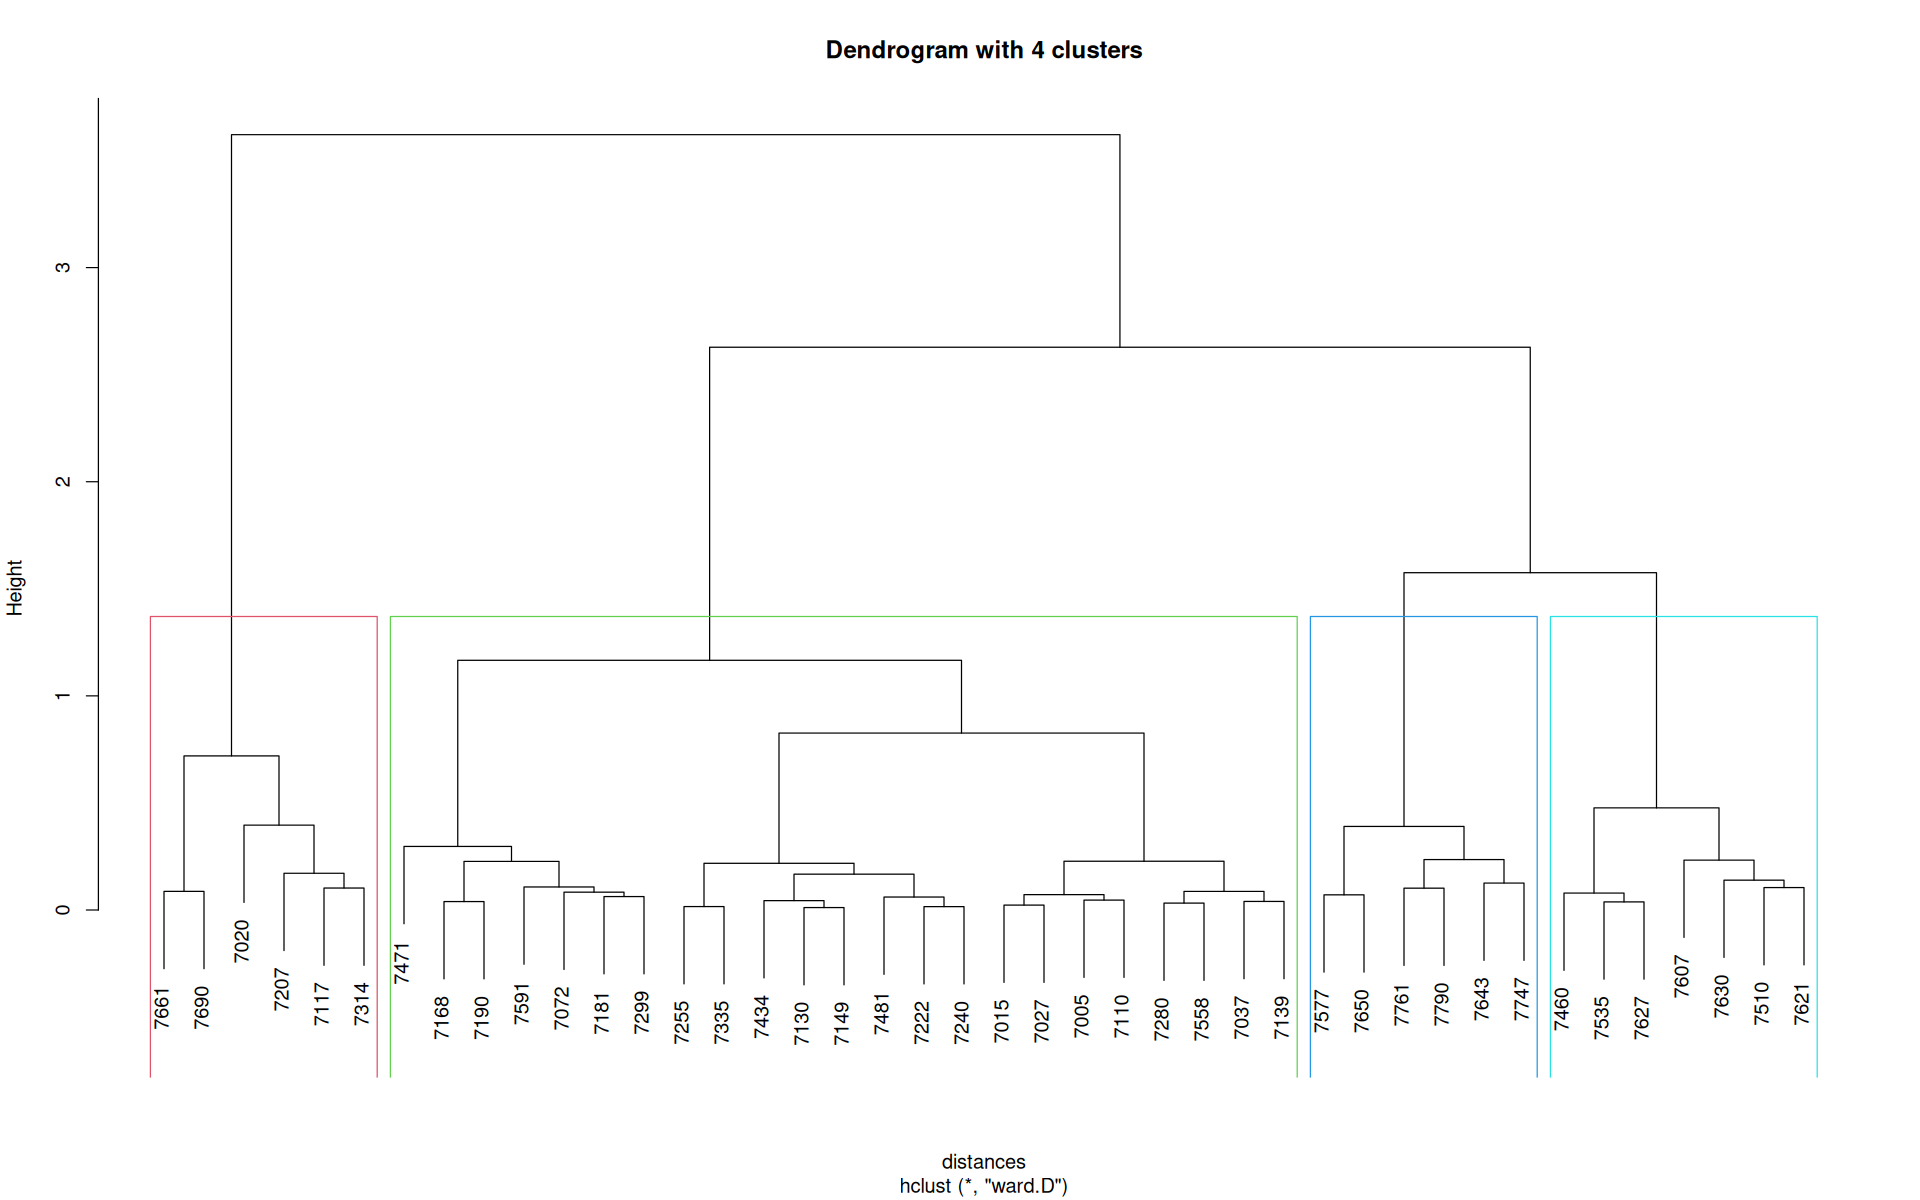

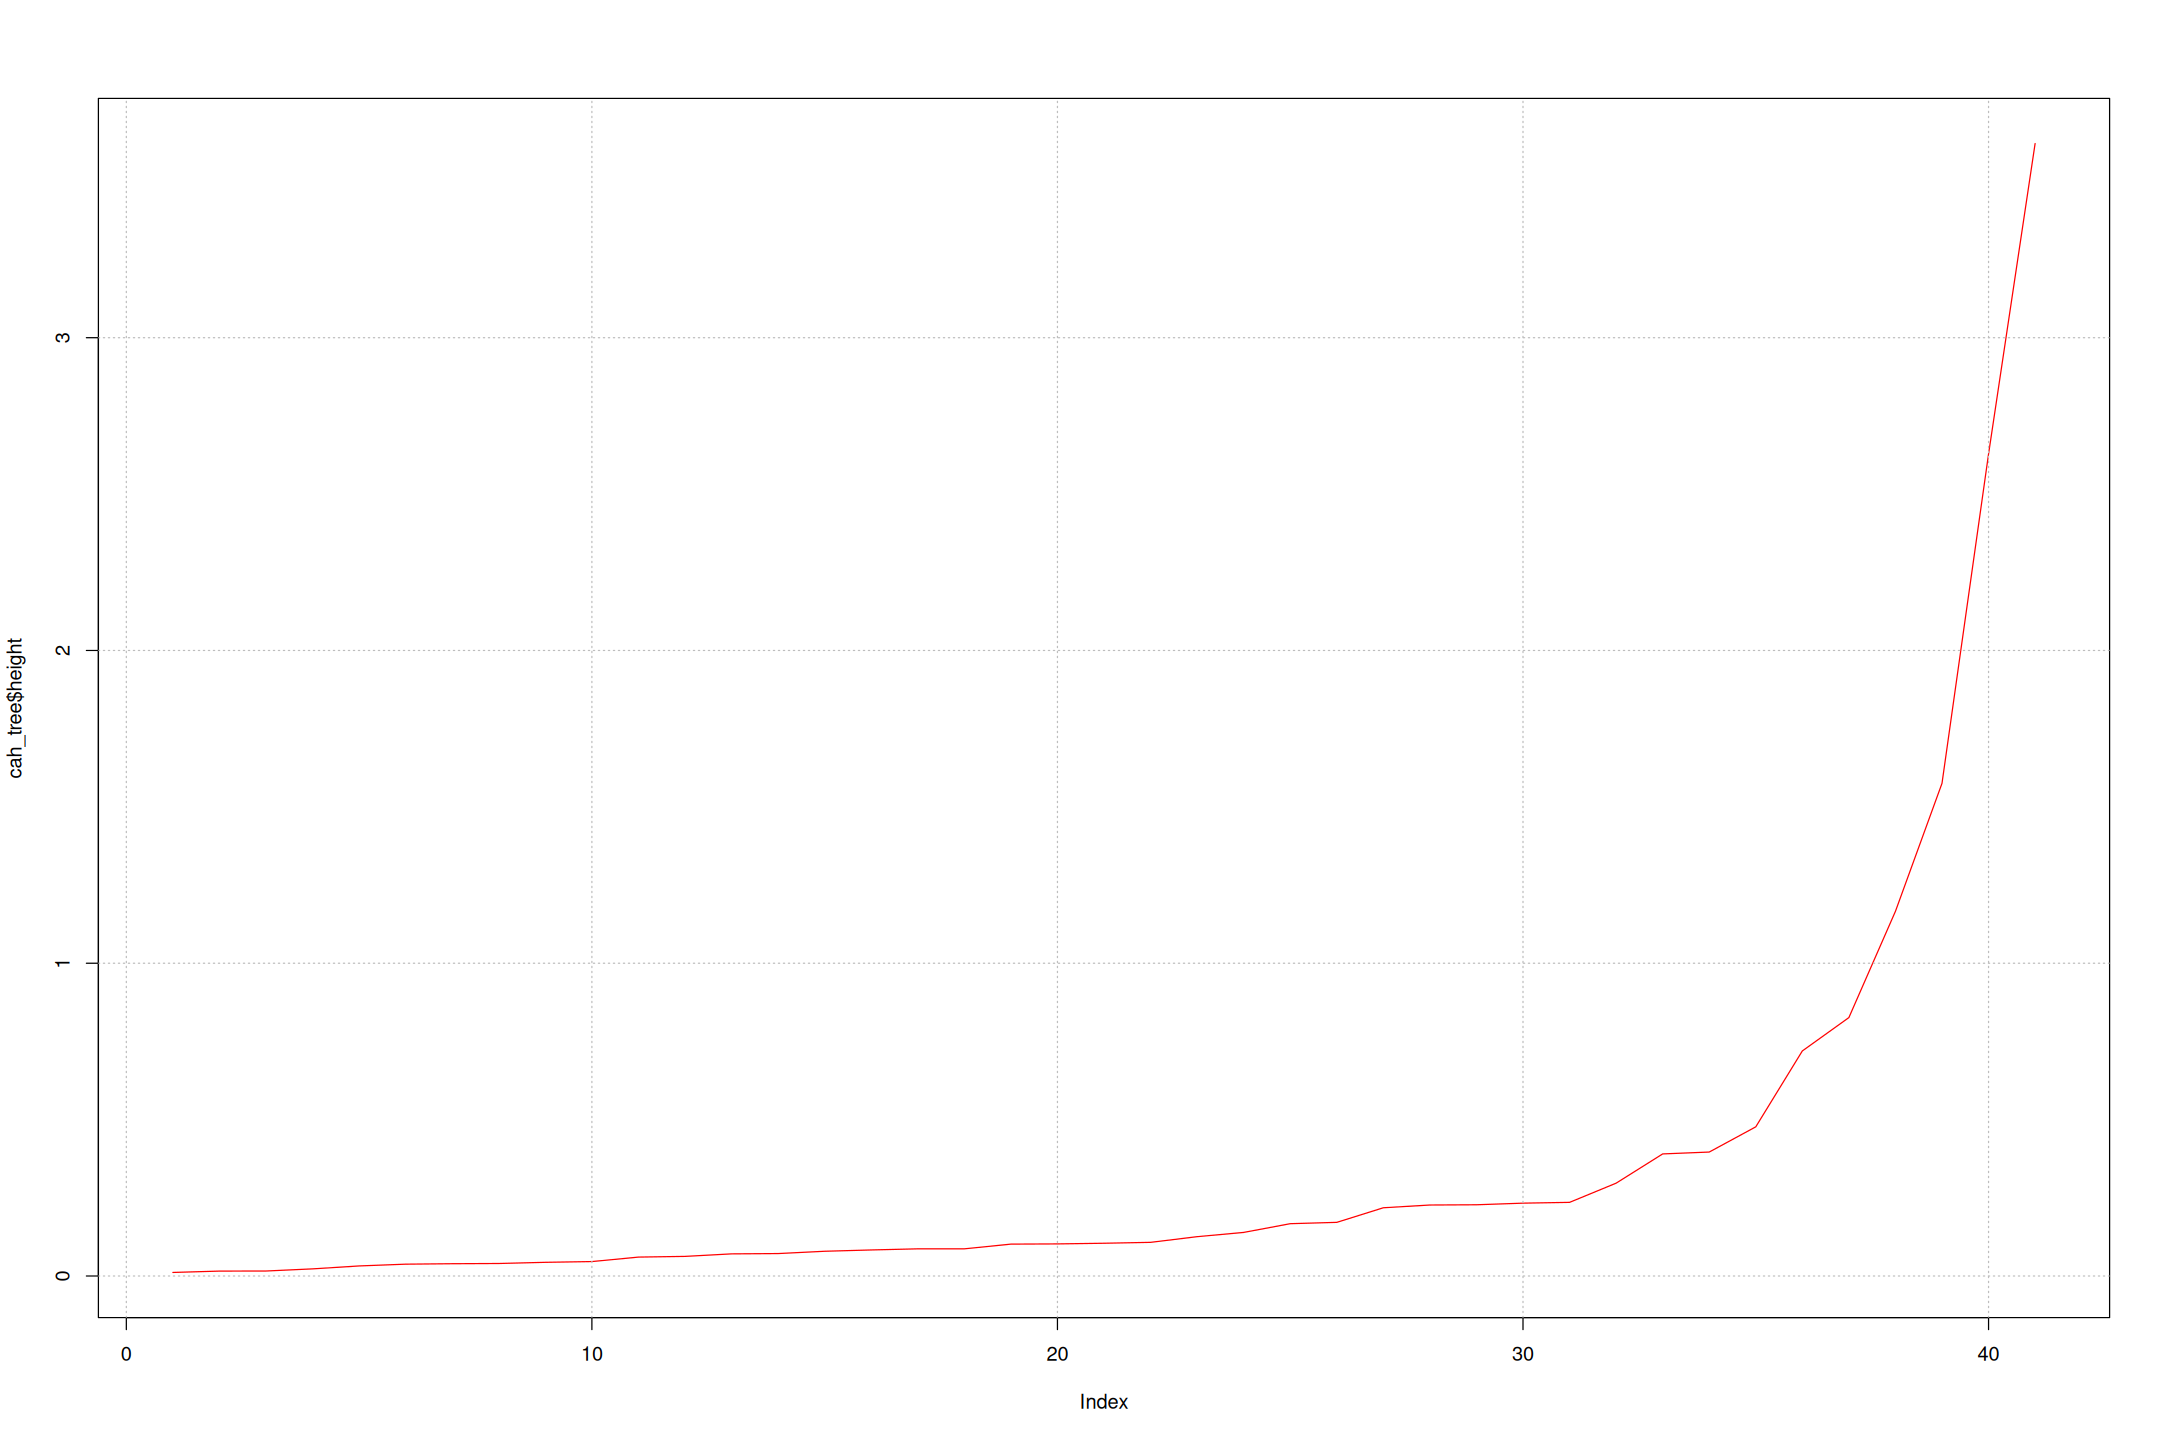

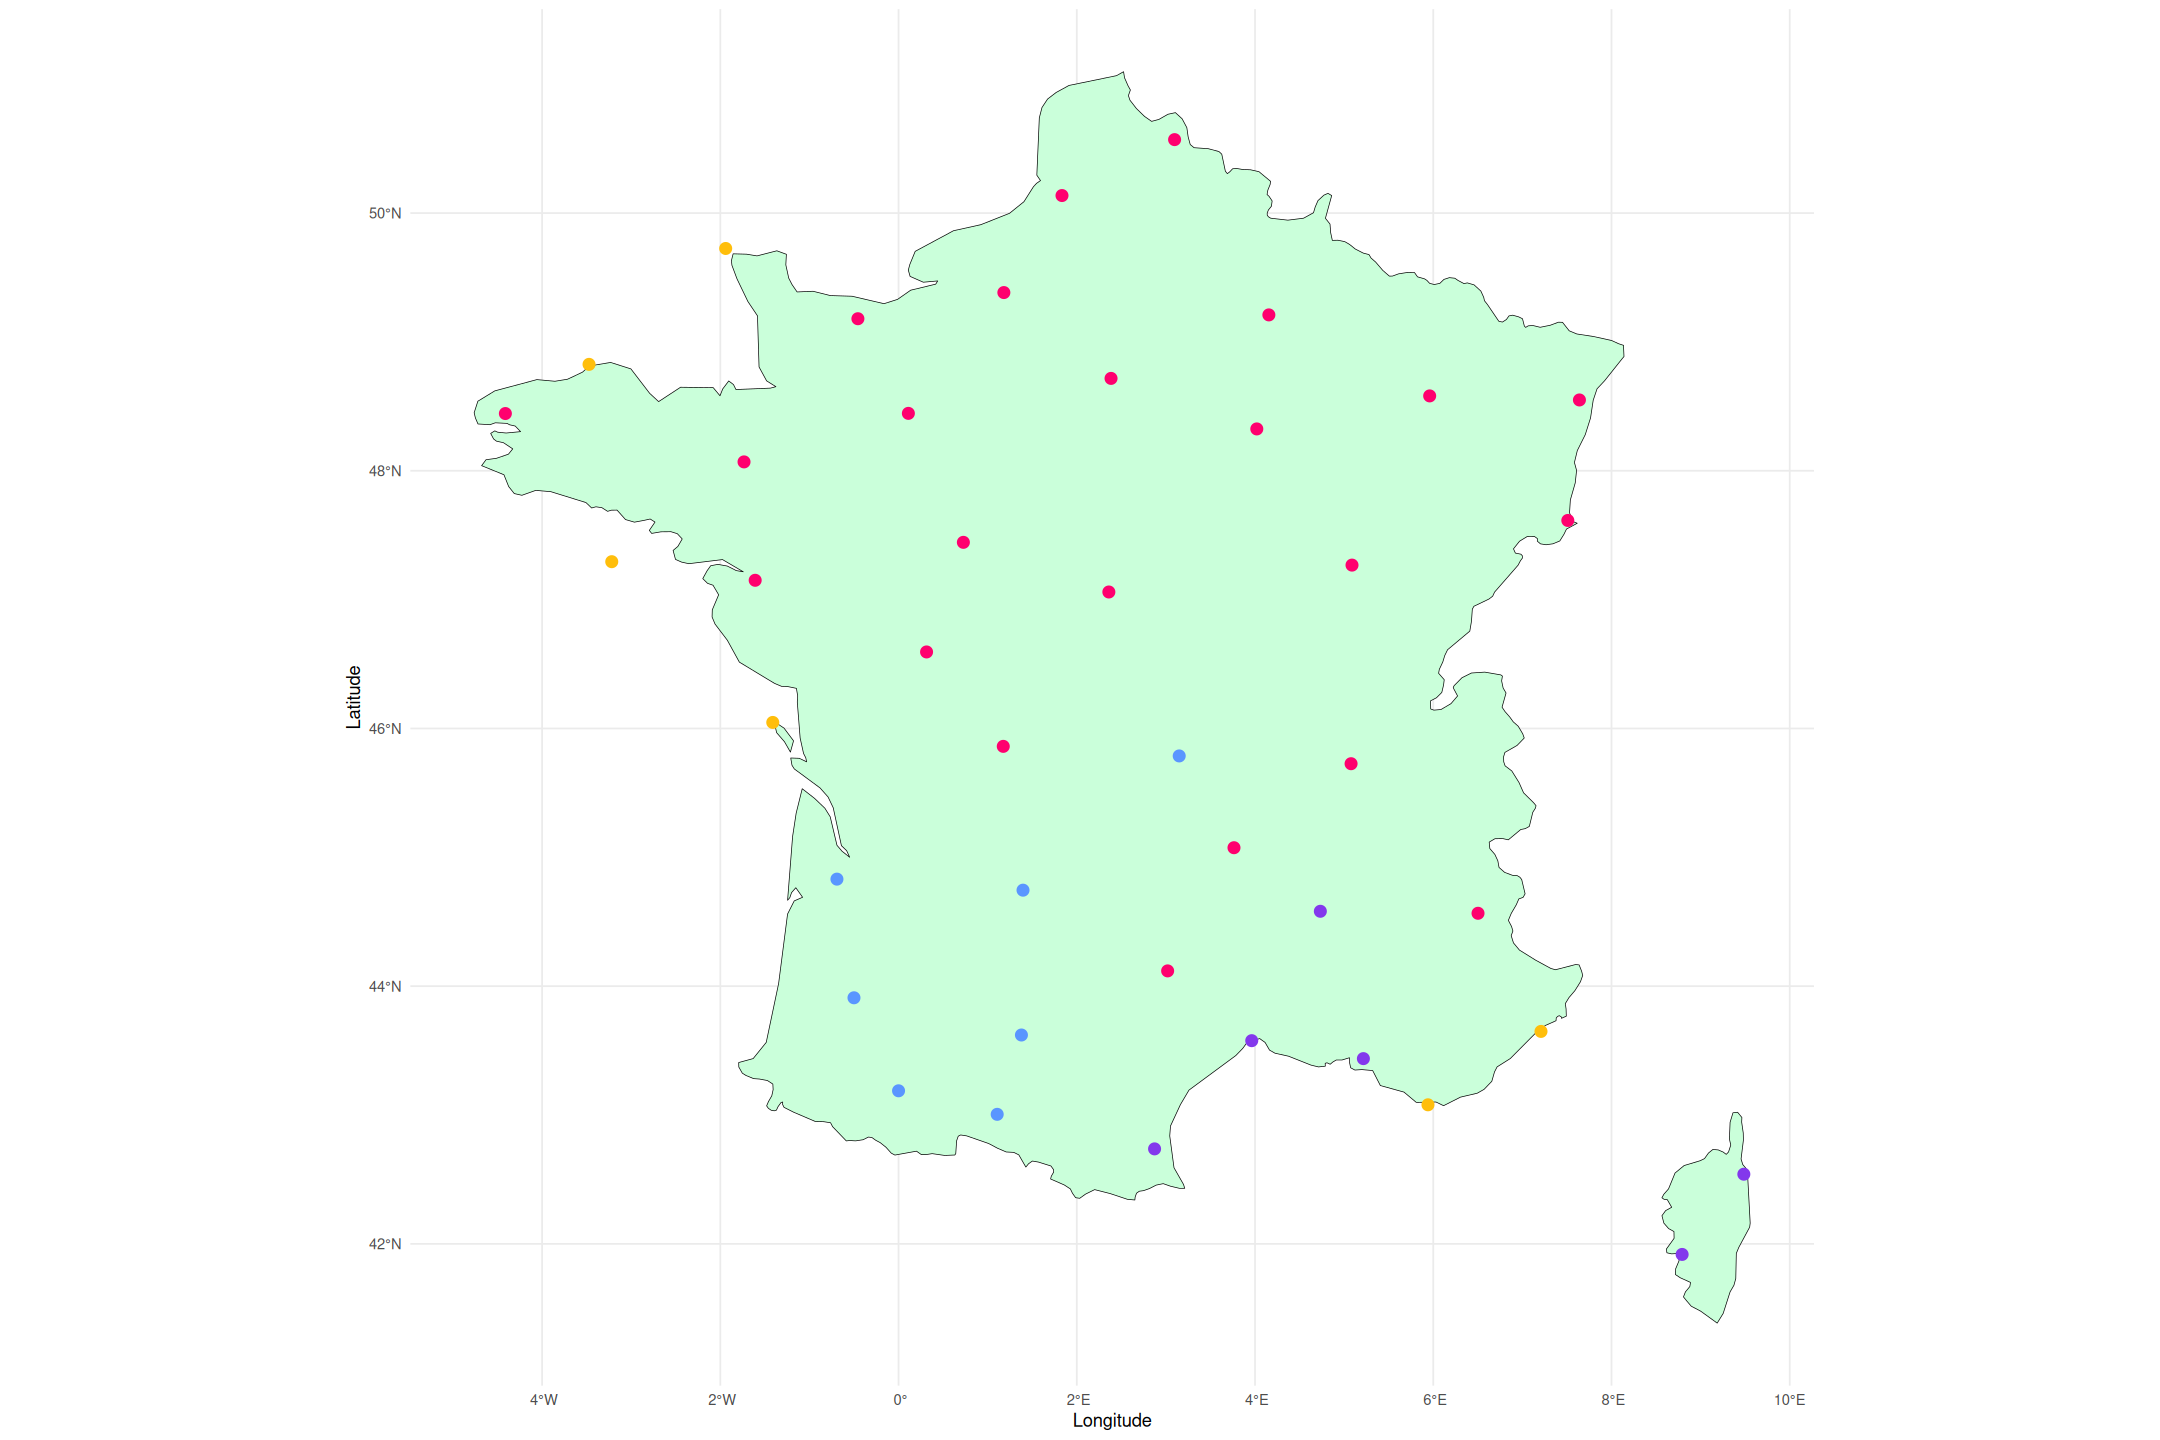

In [96]:
# display dendogram and map
auto_dendogram(temperature_monthly_avg_data, nk=4, metro=metro)

On voit que les stations du bord méditarrennéen et Camargue sont presque toutes regroupées. Lerux stations méditerrannéennes sont regroupées avec d'autres stations du littoral breton. Seule Brest fait bande à part en Bretagne. Peut-être est-ce due au fait que la station est implantée en ville, modifiant les températures minimales et maximales.

Les autres stations représentent globalement l'intérieur des terres, avec un climat chaud pour le groupe Occitan, et un climat plus froid ailleurs.

Ce dendogramme permet par ailleurs d'affirmer que Lyon est dans le Nord selon ce critère.

## Critère : Nébulosité, pression, Tmin et Tmax moyen par jour

Crée le dataframe avec les données nécessaires pour le dendrogramme. Exécute la fonction de dendrogrammage. Expérimentalement, nk=3 fonctionne bien pour les données monde et métropole.

Le regroupement des stations se fait sur les températures maximales et minimales calculées chaque mois ainsi que pour la nébulosité et la pression station, pour toutes les années. Par exemple, la température minimale de la station 7005, pour les mois de septembre de toutes les année.

In [97]:
# extract two columns temperatures for each station
TNP_data <- full_data[, c("ID.OMM.station", "Température...C.", "Température...C.", "mois_de_l_annee", "Pression.station", "Nebulosité.totale", "Latitude", "Longitude")]
colnames(TNP_data) = c("ID.OMM.station", "TempératureMin", "TempératureMax", "Mois", "Pression.station", "Nebulosité.totale", "Latitude", "Longitude")

# group temperatures by month and station, and take min and max for each month
TNP_monthly_data <- TNP_data %>% 
                    group_by(ID.OMM.station, Mois) %>% 
                    summarise(TempératureMin = min(TempératureMin, na.rm = TRUE),
                                TempératureMax = max(TempératureMax, na.rm = TRUE),
                                PressionMoy = mean(Pression.station, na.rm=TRUE),
                                NebulositeMoy = mean(Nebulosité.totale, na.rm=TRUE),
                                Latitude = min(Latitude, na.rm = TRUE),
                                Longitude = min(Longitude, na.rm = TRUE))

# change format of dataframe : each column is duplicated (on column per data per month (yearly))
TNP_wide <- TNP_monthly_data %>%
  pivot_wider(
    id_cols = c(ID.OMM.station, Latitude, Longitude),
    names_from = Mois,
    values_from = c(TempératureMin, TempératureMax, PressionMoy, NebulositeMoy),
    names_sep = "_",
    names_glue = "{.value}_month{Mois}"
  )

# change row names to station nameds
TNP_wide <- as.data.frame(TNP_wide)
row.names(TNP_wide) <- TNP_wide$ID.OMM.station
# drop first column
TNP_wide <- TNP_wide[, -which(names(TNP_wide) == "ID.OMM.station")]



`summarise()` has grouped output by 'ID.OMM.station'. You can override using
the `.groups` argument.


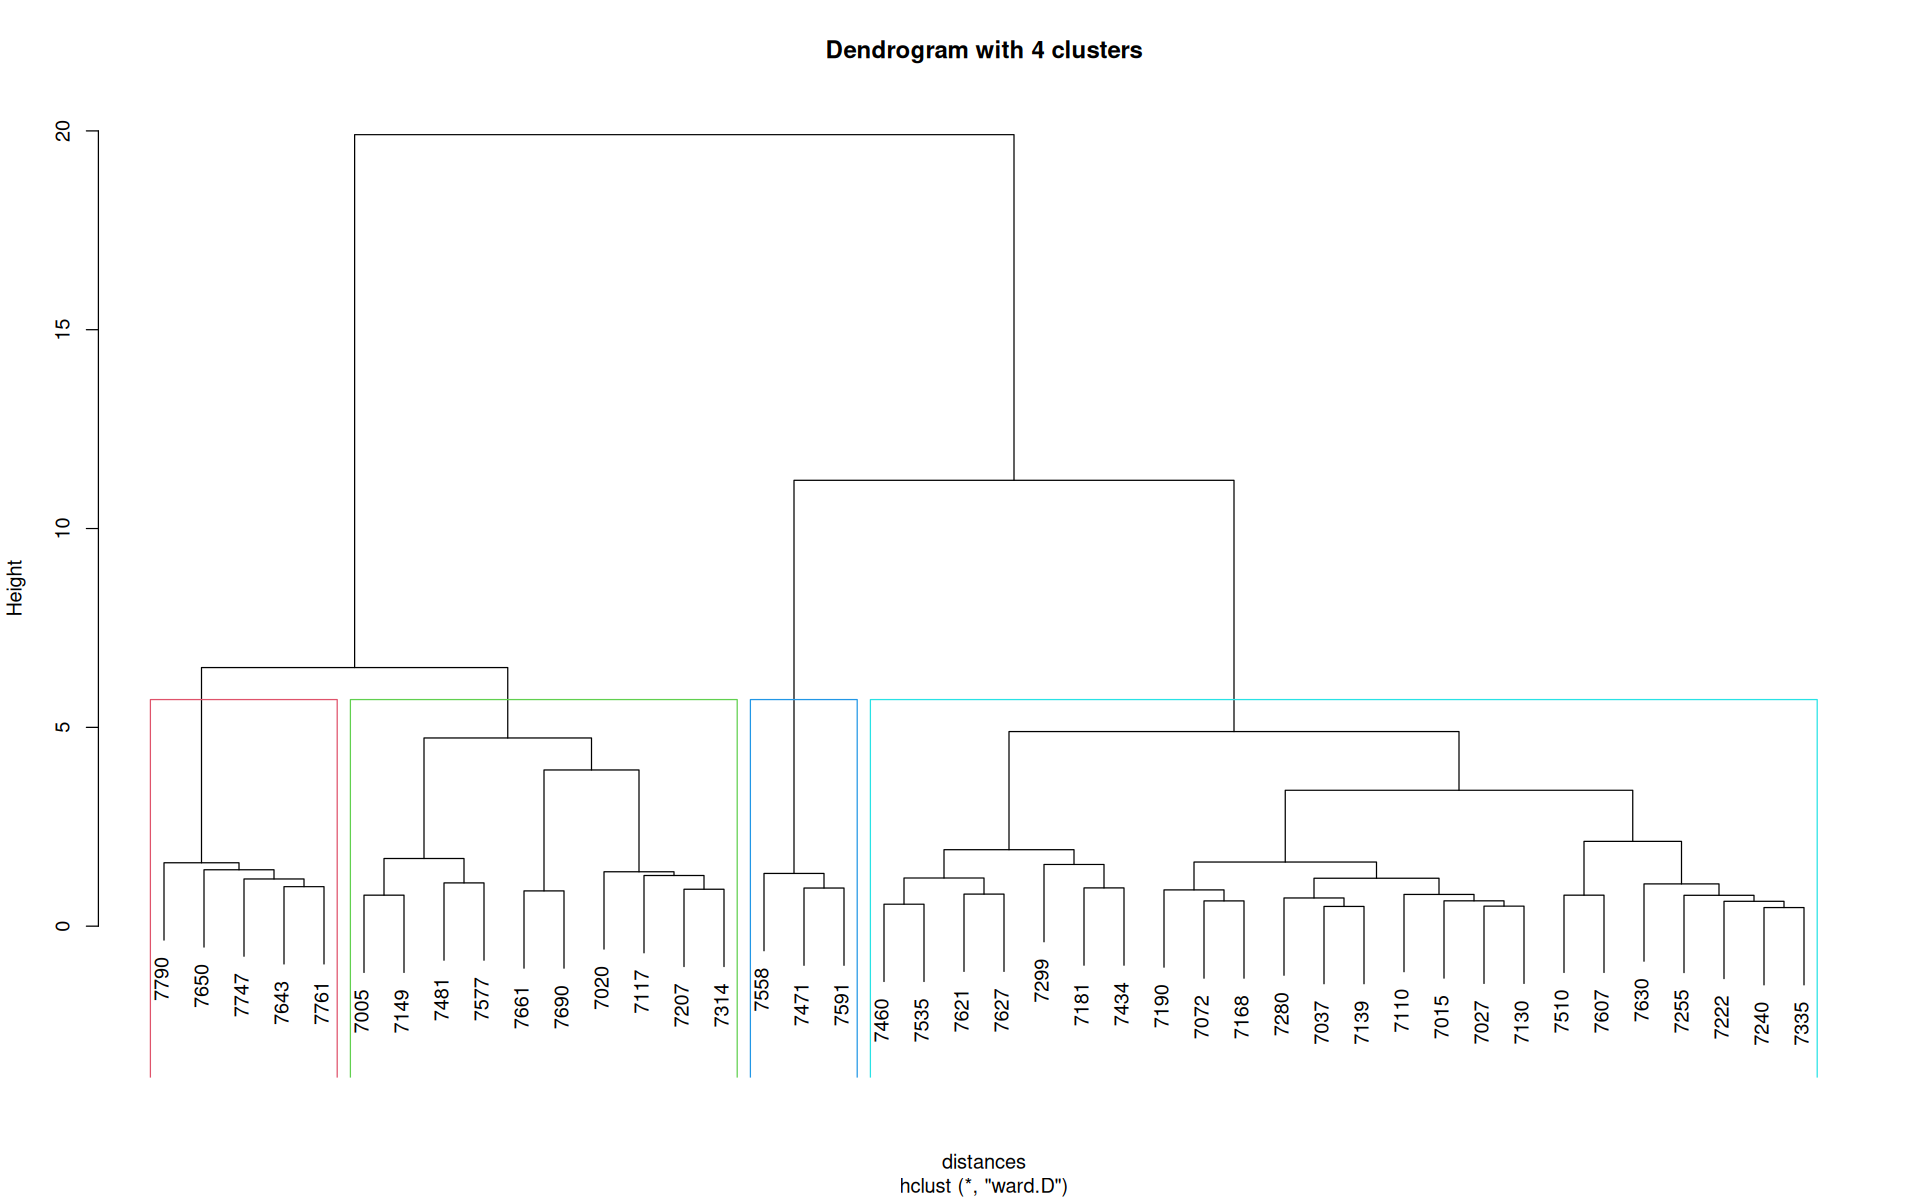

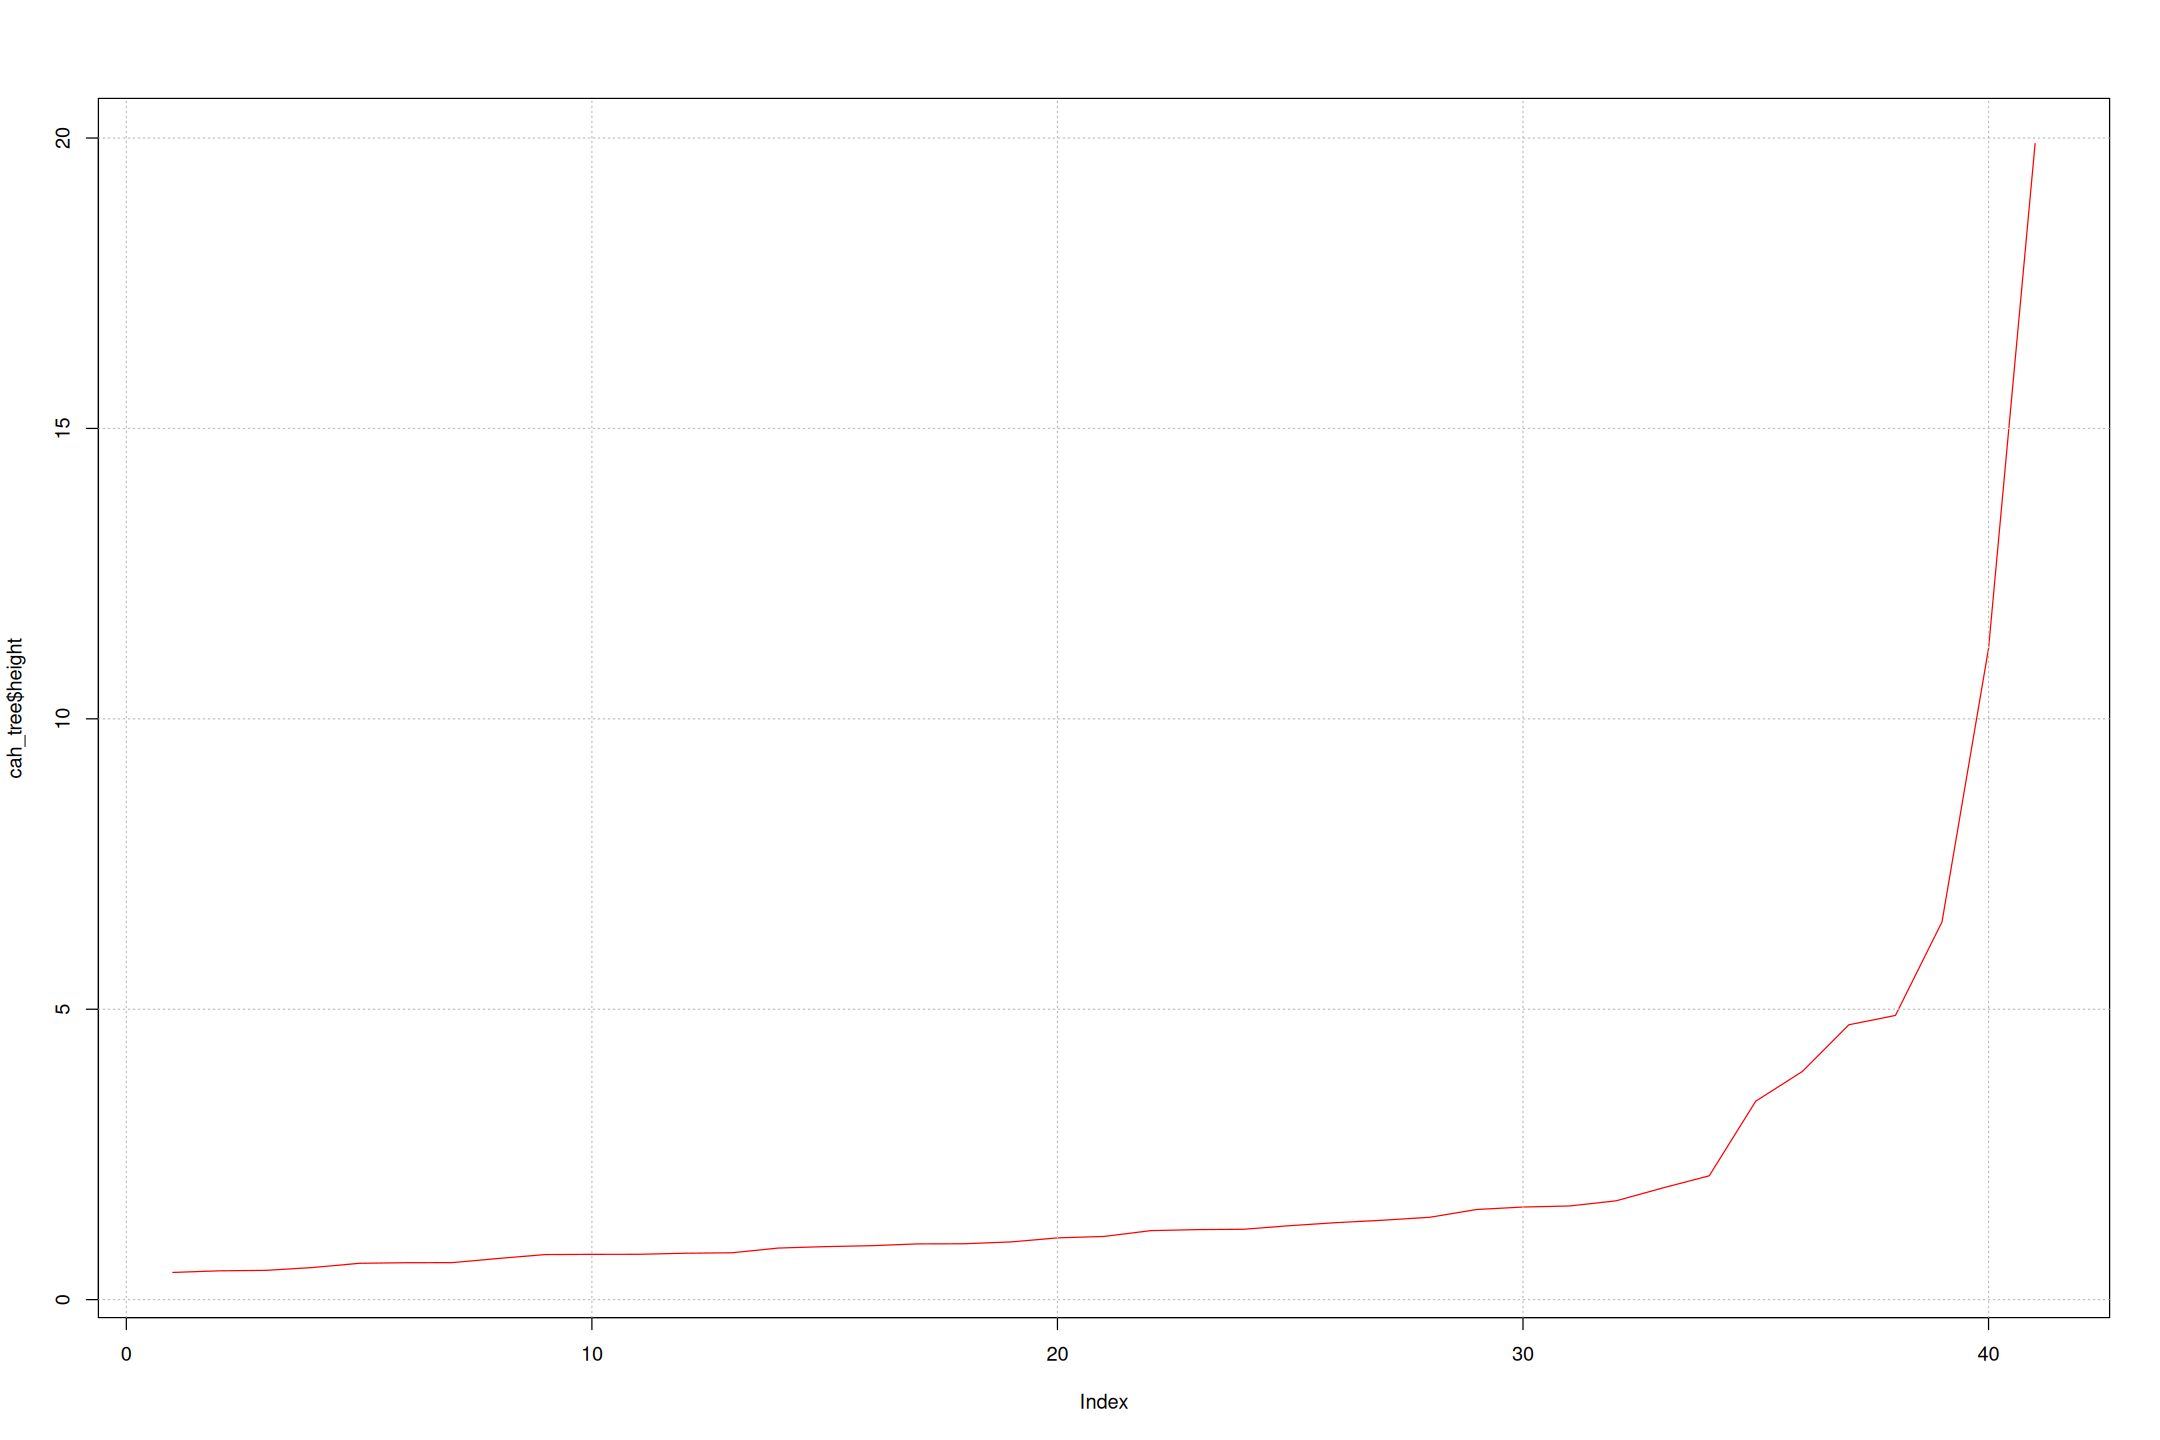

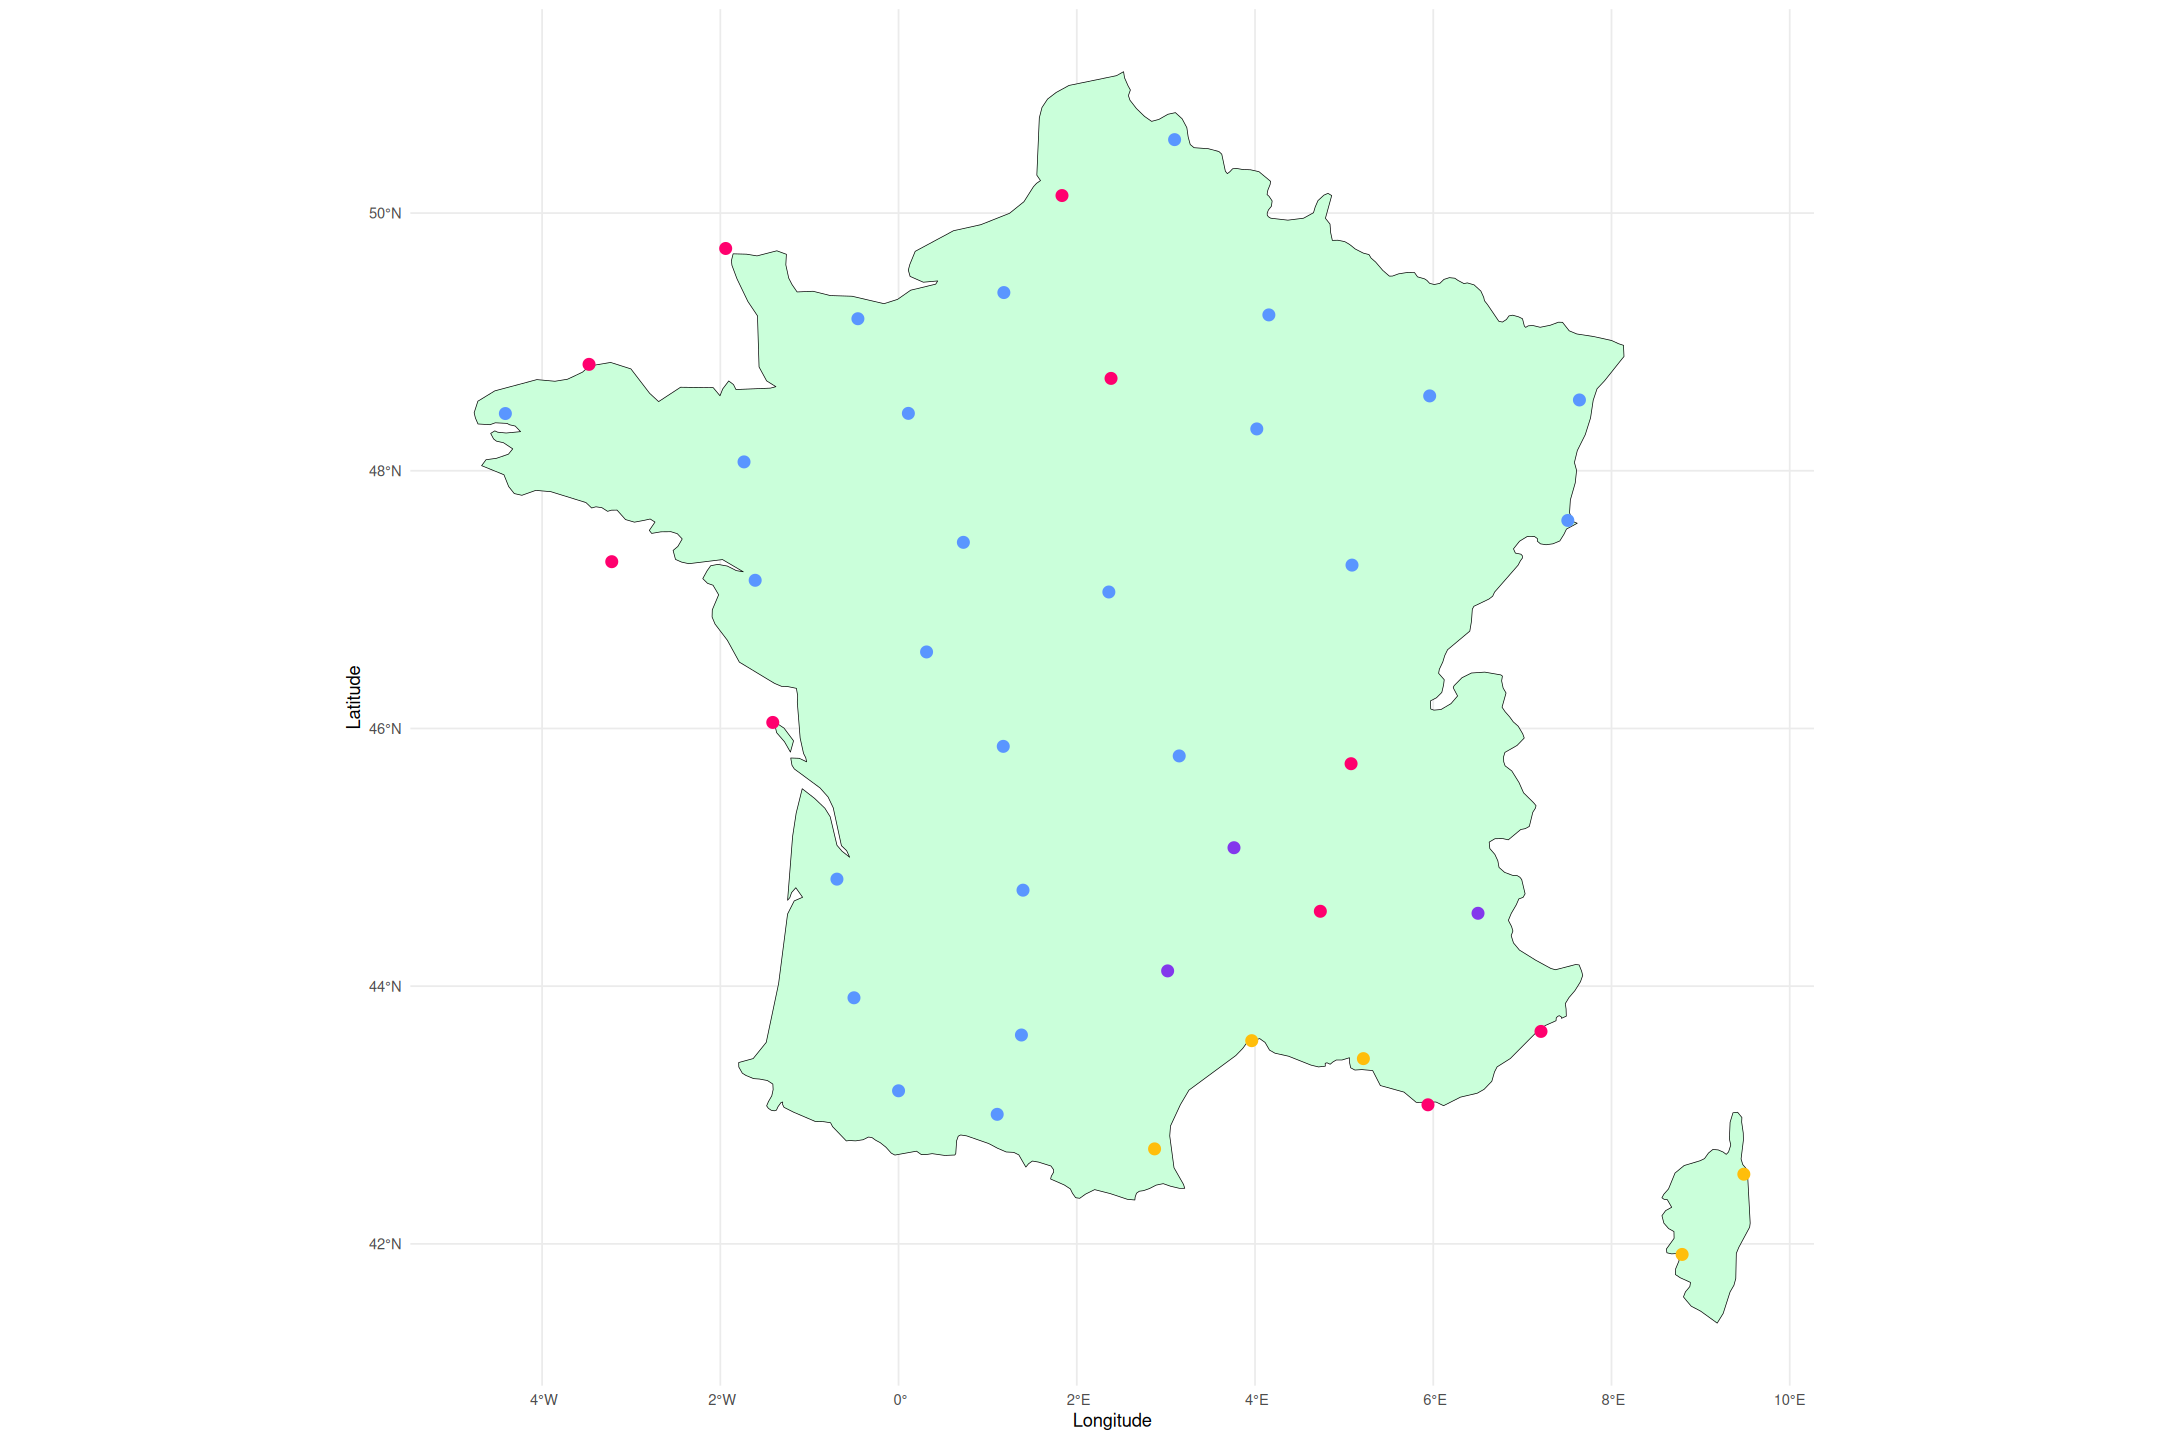

In [99]:
# display dendogram and map
auto_dendogram(TNP_wide, nk=4, metro=metro)

Ce regroupement diffère du précédent, qui se basait uniquement sur la température. Presque toutes les stations du littoral sont réparties dans les deux mêmes groupes. Ces deux groupes littoraux sont les deux plus proches, peut-être en raison de l'altitude des stations qui implique une pression station plus élevée en bord de mer. Cependant, à l'un des deux groupes s'ajoute les stations de la vallée du Rhône et Paris et Brest. 

On peut proposer la lecture suivant : le groupe jaune (Corse, Côte Vermeil) a une nébulosité faible, des températures hautes et une pression haute.

Le groupe Rose (Paris, Vallée du Rhône, un bout de la Bretagne) est nuageux et connait des minimales assez basse.

Le groupe violet (Autour de la vallée du Rhône) correspon à des zones montagneuses de par et d'autres de la vallée du Rhône, probablement liées par un même climat influencé par les mêmes vents dominants et la même latitude et altitude.

Le groupe bleu correspond à la France continentale. 